This notebook documents how the greatest weighted simple path is found between community route start and end nodes as found in the node ranking process.

In [13]:
import osmnx as ox
import networkx as nx
import pandas as pd
import config
import route_planning.helpers.route_planning_helper as helper

Load the graph where route start and end nodes are flagged.

Then create a subgraph for each community,
this will ensure simple paths found stay within a community's boundaries,
reducing computation time.

In [2]:
%%time
G = ox.load_graphml(filepath=f"{config.rp_graphml_path}/route_start_end_flagged.graphml")

# nodes = ox.graph_to_gdfs(G, edges=False)
# community_labels = list(nodes["community"].unique())

community_graphs = helper.split_into_community_graphs(G)
# for label in community_labels:
#     community_nodes = []
#     for x, y in G.nodes(data=True):
#         if y["community"] == label:
#             community_nodes.append(x)
#     sub = G.subgraph(community_nodes)
#     community_graphs.append(sub)

CPU times: user 1.14 s, sys: 40.2 ms, total: 1.18 s
Wall time: 1.21 s


Adding a boolean community_route flag to all nodes, nodes on the eventual route will have this set to true

In [3]:
nx.set_node_attributes(G, False, "community_route")

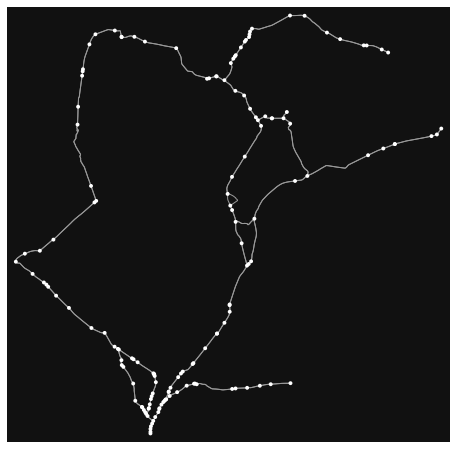

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f323073e430>)

In [11]:
#check = helper.find_highest_weighted_simple_path(community_graphs[1])
#
ox.plot_graph(community_graphs[3])

In [4]:
%%time

#helper.find_highest_weighted_simple_path(community_graphs[1])
routes = []
for graph in community_graphs:
    path = helper.find_highest_weighted_simple_path(graph)
    print(path)
    routes.append(path)
routes

# start_node = None
# end_node = None
# for x, y in community_graphs[0].nodes(data=True):
#     if "route_flag" in y:
#         if y["route_flag"] == "1":
#             start_node = x
#         elif y["route_flag"] == "2":
#             end_node = x
#ox.plot_graph(community_graphs[0], node_size=10)

# heaviest_path = max((path for path in nx.all_simple_paths(community_graphs[0],
#                                                           source=start_node,
#                                                           target=end_node)),
#                     key=lambda path: path_weight(path))
#paths = list(nx.all_simple_paths(community_graphs[0], source=start_node, target=end_node))

[262459232, 2110993824, 2112562727, 2112562550, 258440720, 2112562637, 2112562834, 2114692416, 258430807, 2739577689, 2114692276, 1979831232, 1979830654, 6302291471, 339828849, 2114692414, 258430916, 2114692923, 2114692649, 2679019572, 2114649718, 1557357468, 1976663550, 258431037, 2114650574, 2114649685, 2354772221, 258431074, 1976663072, 2114649669, 258431117, 262482303, 2114650326, 2114649822, 2114649983, 2114650088, 2114650363, 1411721776, 529130810, 1411690486, 891663587, 2115875593, 2115875669, 2115875525, 2115875630, 891663458, 824799710, 2859800089, 1411703035, 528692201, 7313926535, 258661238, 1297382815, 155939804, 1411714691, 258601516, 1411690478, 1411702960, 258601523]
[258453962, 258453976, 258454085, 258454102, 309927034, 258454188, 1984692868, 1984692752, 1557330797, 258454371, 1630123993, 1630123995, 258454421, 258454435, 258449136, 262482278, 1885963573, 1557332267, 262482285, 262482288, 1557324455, 258449094, 258449084, 309963646, 309963645, 2278477863, 843308742, 20

[[262459232,
  2110993824,
  2112562727,
  2112562550,
  258440720,
  2112562637,
  2112562834,
  2114692416,
  258430807,
  2739577689,
  2114692276,
  1979831232,
  1979830654,
  6302291471,
  339828849,
  2114692414,
  258430916,
  2114692923,
  2114692649,
  2679019572,
  2114649718,
  1557357468,
  1976663550,
  258431037,
  2114650574,
  2114649685,
  2354772221,
  258431074,
  1976663072,
  2114649669,
  258431117,
  262482303,
  2114650326,
  2114649822,
  2114649983,
  2114650088,
  2114650363,
  1411721776,
  529130810,
  1411690486,
  891663587,
  2115875593,
  2115875669,
  2115875525,
  2115875630,
  891663458,
  824799710,
  2859800089,
  1411703035,
  528692201,
  7313926535,
  258661238,
  1297382815,
  155939804,
  1411714691,
  258601516,
  1411690478,
  1411702960,
  258601523],
 [258453962,
  258453976,
  258454085,
  258454102,
  309927034,
  258454188,
  1984692868,
  1984692752,
  1557330797,
  258454371,
  1630123993,
  1630123995,
  258454421,
  258454435,
  25

In [9]:
all_route_nodes = sum(routes, [])
len(all_route_nodes)

964

In [10]:
for node in all_route_nodes:
    G.nodes[node]["community_route"] = True
community_route_nodes = [x for x,y in G.nodes(data=True) if y["community_route"]]
len(community_route_nodes)

964

In [11]:
nodes, edges = ox.graph_to_gdfs(G)
route_nodes = nodes[(nodes["community_route"])]

route_nodes_graph = ox.graph_from_gdfs(route_nodes, edges)

In [21]:
# convert community labels to integers so that get_node_colors_by_attr can use the community attribute
for x, y in route_nodes_graph.nodes(data=True):
    if "community" in y:
        y["community"] = int(y["community"])

Plot the route start and endpoints, colour based on community

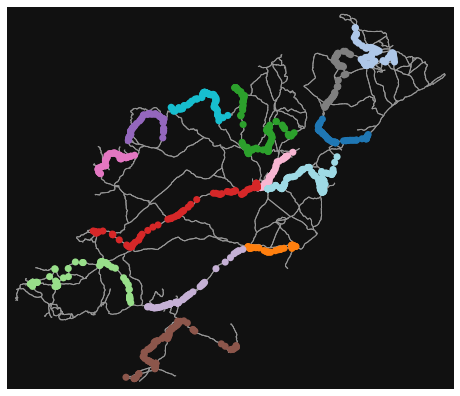

In [22]:
node_colours = ox.plot.get_node_colors_by_attr(route_nodes_graph,
                                               attr="community",
                                               cmap="tab20")

# graph_from_gdfs creates empty nodes so need
# to update node_colours to include those so
# that plot graph function will work correctly
all_nodes = route_nodes_graph.nodes(data=True)

other_nodes = {x: (0, 0, 0, 0) for x, y in G.nodes(data=True) if x not in node_colours.index}
series = pd.Series(other_nodes)
node_colours = node_colours.append(series)

fig, ax = ox.plot_graph(route_nodes_graph, node_color=node_colours, node_size=50)
